In [30]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [31]:
day = "0810"
name_notebook = day + "-sh_em_1qm_v2.ipynb"

#ask the user if that is correct, if he says yes kkep going, otherwise stop
import sys
answer = input("{} is the name of the notebook | Is that correct? (y/n): ".format(name_notebook))
if answer != "y":
    print("Please, change the name of the notebook")
    sys.exit()

In [32]:
import numpy as np

In [33]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [34]:
data_file_path = initial_path + 'data/Scores/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(data_file_path)
score_list = np.array(number_list)
vector_list = np.array([f.string_to_numbers(string) for string in string_list]) # one hot encoding

In [35]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

In [36]:
# Define the dataset
input_data = ptm.torch.tensor(X) 
target_data = ptm.torch.tensor(Y).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation)
target_validation = ptm.torch.tensor(Y_validation).view(-1, 1)

In [37]:
input_data.shape, target_data.shape, input_validation.shape, target_validation.shape

(torch.Size([9000, 4]),
 torch.Size([9000, 1]),
 torch.Size([1000, 4]),
 torch.Size([1000, 1]))

# Quantum node

In [38]:
n_aminoacids = len(string_list[0])

In [39]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    embedding_ansatz = qn.parts.Ansatz_11,
    block_ansatz = qn.parts.Ansatz_11,
    measurement = qn.parts.Measurement('Z', 1),
    embedding_n_layers = 4,
    different_inputs_per_layer = True,
    block_n_layers = 50,
    # wrapper_qlayer = pw.QLayer,
    wrapper_qlayer = None,
)

In [40]:
quantum_layer.weights_shape, quantum_layer.input_shape

({'embedding_weights': (48,), 'block_weights': (600,)}, (20,))

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

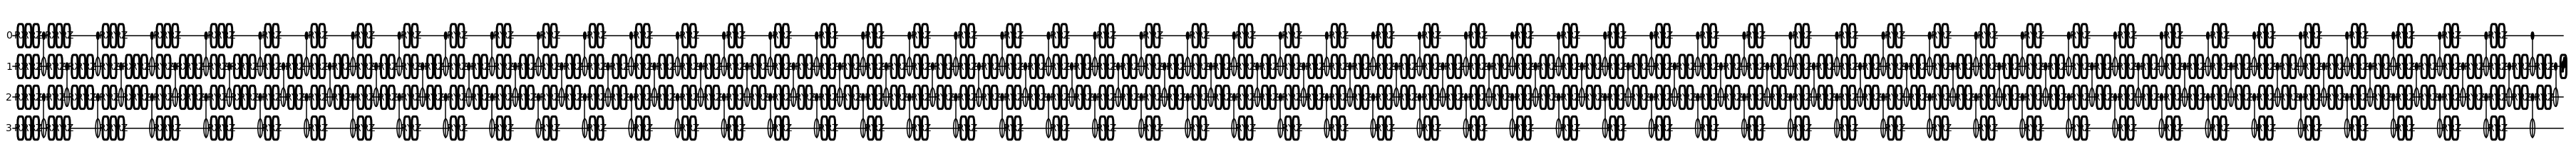

In [41]:
quantum_layer.draw(size=(50,3))

# Hybrid model

In [42]:
input_dim = input_data.size(1)

n_pre_classical_layers = 4
layers_dim = np.linspace(n_aminoacids, input_dim, 4).astype(int)

In [43]:
import torch.nn as nn
import torch
class ClippedReLU(nn.Module):
    def __init__(self, clip_val=1):
        super(ClippedReLU, self).__init__()
        self.clip_val = clip_val

    def forward(self, x):
        return torch.clamp(x, 0, self.clip_val)
    
class Reshape(nn.Module):
    def __init__(self):
        super(Reshape, self).__init__()

    def forward(self, x):
        dims = len(x.shape)
        return torch.transpose(x, dims-2, dims-1).reshape(x.shape[-3] if dims==3 else 1, x.shape[-2]*x.shape[-1]).squeeze()

In [44]:
layers =  [ptm.nn.Embedding(num_embeddings=19, embedding_dim=quantum_layer.input_shape[0]//n_aminoacids), Reshape()]
layers += [quantum_layer(), ptm.nn.Linear(1,1)]


In [45]:
# layers = []
# for i in range(1, len(layers_dim)):
#     layers += [ptm.nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), ptm.nn.ReLU()]
# layers += [ptm.nn.Linear(layers_dim[0], layers_dim[0]), ClippedReLU()]
# layers += [quantum_layer()]
# # layers += [nn.Linear(1, 1)]
# # layers += [nn.Linear(2, 4), nn.ReLU()]
# # layers += [nn.Linear(4, 1)]

In [46]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [47]:
x = input_data[0:2]
for i, layer in enumerate(model.model):
    x = layer(x)
    print(i, x.shape, x)

0 torch.Size([2, 4, 5]) tensor([[[-1.1346,  0.5462, -1.3516,  0.9041, -1.2927],
         [-0.0891,  0.8278,  0.5477, -1.3102, -1.2461],
         [ 0.5552,  1.6280,  0.2475,  1.1846,  1.2027],
         [ 0.2820,  0.4058,  0.0841, -0.4611,  0.1700]],

        [[ 0.2884,  1.6460, -0.2311, -0.3078, -1.7481],
         [ 0.8847, -2.5227, -0.8462,  1.5590,  0.9098],
         [-0.2652, -0.2028,  0.7898, -1.5777,  1.5194],
         [ 0.5552,  1.6280,  0.2475,  1.1846,  1.2027]]],
       grad_fn=<EmbeddingBackward>)
1 torch.Size([2, 20]) tensor([[-1.1346, -0.0891,  0.5552,  0.2820,  0.5462,  0.8278,  1.6280,  0.4058,
         -1.3516,  0.5477,  0.2475,  0.0841,  0.9041, -1.3102,  1.1846, -0.4611,
         -1.2927, -1.2461,  1.2027,  0.1700],
        [ 0.2884,  0.8847, -0.2652,  0.5552,  1.6460, -2.5227, -0.2028,  1.6280,
         -0.2311, -0.8462,  0.7898,  0.2475, -0.3078,  1.5590, -1.5777,  1.1846,
         -1.7481,  0.9098,  1.5194,  1.2027]], grad_fn=<SqueezeBackward0>)


2 torch.Size([2, 1]) tensor([[-0.0207],
        [ 0.0806]], grad_fn=<ViewBackward>)
3 torch.Size([2, 1]) tensor([[-0.3408],
        [-0.3455]], grad_fn=<AddmmBackward>)


In [48]:
for i in range(2):
    x = input_data[i]
    for i, layer in enumerate(model.model):
        x = layer(x)
        print(i, x.shape, x)

    print('')

0 torch.Size([4, 5]) tensor([[-1.1346,  0.5462, -1.3516,  0.9041, -1.2927],
        [-0.0891,  0.8278,  0.5477, -1.3102, -1.2461],
        [ 0.5552,  1.6280,  0.2475,  1.1846,  1.2027],
        [ 0.2820,  0.4058,  0.0841, -0.4611,  0.1700]],
       grad_fn=<EmbeddingBackward>)
1 torch.Size([20]) tensor([-1.1346, -0.0891,  0.5552,  0.2820,  0.5462,  0.8278,  1.6280,  0.4058,
        -1.3516,  0.5477,  0.2475,  0.0841,  0.9041, -1.3102,  1.1846, -0.4611,
        -1.2927, -1.2461,  1.2027,  0.1700], grad_fn=<SqueezeBackward0>)
2 torch.Size([1]) tensor([-0.0207], grad_fn=<CatBackward>)
3 torch.Size([1]) tensor([-0.3408], grad_fn=<AddBackward0>)

0 torch.Size([4, 5]) tensor([[ 0.2884,  1.6460, -0.2311, -0.3078, -1.7481],
        [ 0.8847, -2.5227, -0.8462,  1.5590,  0.9098],
        [-0.2652, -0.2028,  0.7898, -1.5777,  1.5194],
        [ 0.5552,  1.6280,  0.2475,  1.1846,  1.2027]],
       grad_fn=<EmbeddingBackward>)
1 torch.Size([20]) tensor([ 0.2884,  0.8847, -0.2652,  0.5552,  1.6460, 

In [49]:
print(model(input_data[0:2]))
print(model(input_data[1]))

tensor([[-0.3408],
        [-0.3455]], grad_fn=<AddmmBackward>)
tensor([-0.3455], grad_fn=<AddBackward0>)


In [50]:
model.keep_track_params=False,

In [51]:
import torch.optim as optim

# ask the user if he wants to start the training
out = input("Do you want to start the training? (y/n) ")
if out != 'y':
    sys.exit()

# train the model
model.train(
    optimizer= optim.SGD,
    optimizer_options={'lr': 1},
    num_epochs = 50,                
    batch_size = 32,
    initialization_options = [
        {
            'type': 'normal_',
            'layer': len(model.model)-1, 
            'name': 'bias',
            'options': {'mean': 100, 'std': 10},
        },{
            'type': 'normal_',
            'layer': len(model.model)-1,
            'name': 'weight',
            'options': {'mean': 200, 'std': 10},
        },
    ]
)

Epoch [0/50], Loss: 1.1285, Loss validation: 1.1992
	 Validation string, 	 i: 0; 	 prediction: 12.1711, 	 target: -62.7310, 	 loss: 1.1940
	 Validation string, 	 i: 1; 	 prediction: 174.7702, 	 target: -74.7800, 	 loss: 3.3371
	 Validation string, 	 i: 2; 	 prediction: 116.2745, 	 target: -57.5150, 	 loss: 3.0216
Epoch [1/50], Loss: 1.1701, Loss validation: 1.2519, Time remaining: ~1.0h 35.0m 38s
	 Validation string, 	 i: 0; 	 prediction: 29.5877, 	 target: -62.7310, 	 loss: 1.4717
	 Validation string, 	 i: 1; 	 prediction: 36.6309, 	 target: -74.7800, 	 loss: 1.4898
	 Validation string, 	 i: 2; 	 prediction: 96.4102, 	 target: -57.5150, 	 loss: 2.6763
Epoch [2/50], Loss: 1.1662, Loss validation: 1.2167, Time remaining: ~1.0h 29.0m 12s
	 Validation string, 	 i: 0; 	 prediction: 17.3463, 	 target: -62.7310, 	 loss: 1.2765
	 Validation string, 	 i: 1; 	 prediction: 41.7236, 	 target: -74.7800, 	 loss: 1.5580
	 Validation string, 	 i: 2; 	 prediction: 122.9383, 	 target: -57.5150, 	 loss:

In [52]:
# save string of the model
model.save_str(
    metadata={
        "data_file_path": data_file_path,
    }
)

Saved in:  peptide-QML/checkpoints/0810/txts/0810-sh_em_1qm_v2_model_str_6.txt


Saved in:  peptide-QML/checkpoints/0810/plots/0810-sh_em_1qm_v2_losses_batches_6.png


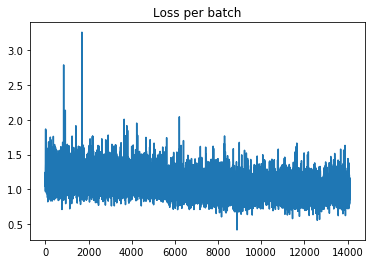

Saved in:  peptide-QML/checkpoints/0810/plots/0810-sh_em_1qm_v2_losses_epoch_6.png


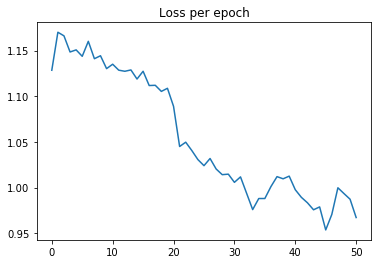

Saved in:  peptide-QML/checkpoints/0810/plots/0810-sh_em_1qm_v2_losses_epoch_validation_6.png


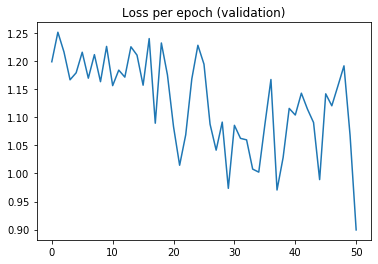

In [53]:
# plot the losses of the trainig loop and save the figures
model.plot_losses(save=True)

Saved in:  peptide-QML/checkpoints/0810/plots/0810-sh_em_1qm_v2_parameter_0.weight_None_6.png


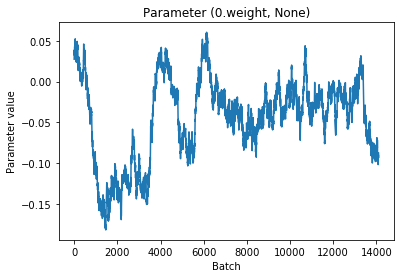

Saved in:  peptide-QML/checkpoints/0810/plots/0810-sh_em_1qm_v2_parameter_2.embedding_weights_None_6.png


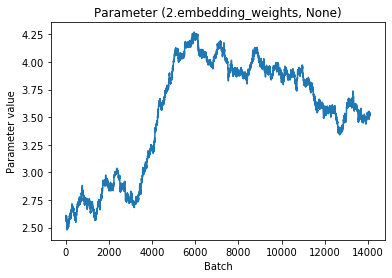

Saved in:  peptide-QML/checkpoints/0810/plots/0810-sh_em_1qm_v2_parameter_2.block_weights_None_6.png


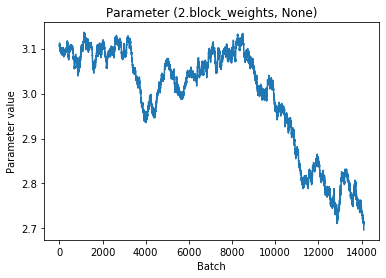

Saved in:  peptide-QML/checkpoints/0810/plots/0810-sh_em_1qm_v2_parameter_3.weight_None_6.png


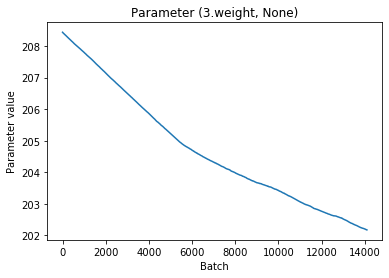

Saved in:  peptide-QML/checkpoints/0810/plots/0810-sh_em_1qm_v2_parameter_3.bias_None_6.png


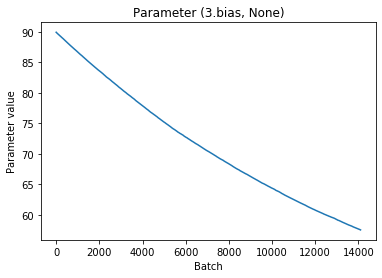

In [54]:
# plot how the average of the parameters in each layer changes over time, and save that
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer, save=True)

In [55]:
# model.plot_parameter(layer='7.weights', index=50)

In [56]:
#save all the parameters of the model and the intermediate parameters of the model
model.save_state_dict(intermediate=False)

Model saved as peptide-QML/checkpoints/0810/models/0810-sh_em_1qm_v2_6.pth


Saved in:  peptide-QML/checkpoints/0810/plots/0810-sh_em_1qm_v2_validation_6.png


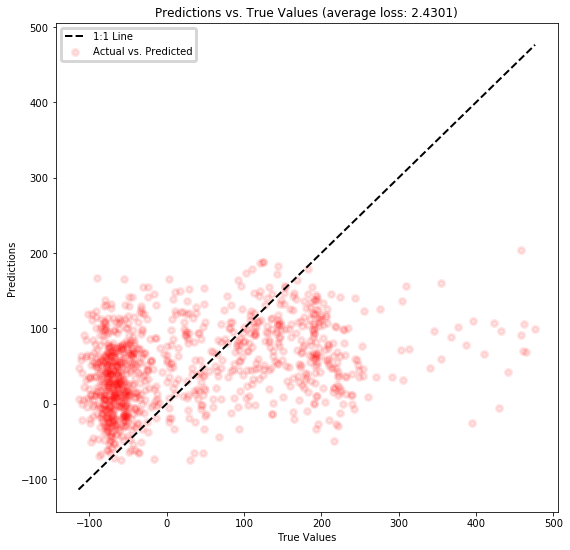

In [57]:
model.plot_validation(save=True, fig_size=(9,9))

In [58]:
# print validation and save it
model.print_validation(save=True, precision=4, percentatge=1)

i: 0, 		 target: -62.7310, 	 prediction: 53.6961, 	 loss: 1.8560
i: 1, 		 target: 215.6070, 	 prediction: 21.1458, 	 loss: 0.9019
i: 2, 		 target: 32.4500, 	 prediction: 46.7349, 	 loss: 0.4402
i: 3, 		 target: -58.9450, 	 prediction: 77.0251, 	 loss: 2.3067
i: 4, 		 target: -104.9950, 	 prediction: 61.3873, 	 loss: 1.5847
i: 5, 		 target: 248.8490, 	 prediction: 35.0155, 	 loss: 0.8593
i: 6, 		 target: 219.8570, 	 prediction: 55.0034, 	 loss: 0.7498
i: 7, 		 target: 313.7060, 	 prediction: 72.3572, 	 loss: 0.7693
i: 8, 		 target: 0.2170, 	 prediction: 57.3217, 	 loss: 263.1551
i: 9, 		 target: 189.7160, 	 prediction: 97.9663, 	 loss: 0.4836
i: 10, 		 target: -74.7800, 	 prediction: 41.4627, 	 loss: 1.5545
i: 11, 		 target: -44.1060, 	 prediction: 68.5129, 	 loss: 2.5534
i: 12, 		 target: -62.6080, 	 prediction: 106.7490, 	 loss: 2.7050
i: 13, 		 target: 132.3460, 	 prediction: 18.7518, 	 loss: 0.8583
i: 14, 		 target: 260.0260, 	 prediction: 8.2740, 	 loss: 0.9682
i: 15, 		 target: 17

In [59]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

[main a3aaaaa7] data trained model
 14 files changed, 1044 insertions(+), 1 deletion(-)
 create mode 100644 checkpoints/0810/models/0810-sh_em_1qm_v2_6.pth
 create mode 100644 checkpoints/0810/plots/0810-sh_em_1qm_v2_losses_batches_6.png
 create mode 100644 checkpoints/0810/plots/0810-sh_em_1qm_v2_losses_epoch_6.png
 create mode 100644 checkpoints/0810/plots/0810-sh_em_1qm_v2_losses_epoch_validation_6.png
 create mode 100644 checkpoints/0810/plots/0810-sh_em_1qm_v2_parameter_0.weight_None_6.png
 create mode 100644 checkpoints/0810/plots/0810-sh_em_1qm_v2_parameter_2.block_weights_None_6.png
 create mode 100644 checkpoints/0810/plots/0810-sh_em_1qm_v2_parameter_2.embedding_weights_None_6.png
 create mode 100644 checkpoints/0810/plots/0810-sh_em_1qm_v2_parameter_3.bias_None_6.png
 create mode 100644 checkpoints/0810/plots/0810-sh_em_1qm_v2_parameter_3.weight_None_6.png
 create mode 100644 checkpoints/0810/plots/0810-sh_em_1qm_v2_validation_6.png
 create mode 100644 checkpoints/0810/txts/